# Splitting data

## Import

In [1]:
import sys
import os


import matplotlib
import matplotlib.pylab as plt
import time
import numpy as np
import open3d
from laspy.file import File
from laspy.header import Header

import math

os.environ["PATH"]+=os.pathsep+os.path.dirname(sys.executable)


## Code helper

In [2]:
def las_to_open3d(path):
    """
    Loads an las or laz file and returns an open3d point cloud as well
    as the file's header. This is useful for saving the cloud back to disk
    """    
    inFile = File(path, mode='r')

    xyz = np.zeros((len(inFile.X),3),dtype=np.float32)
    xyz[:,0] = inFile.x
    xyz[:,1] = inFile.y
    xyz[:,2] = inFile.z
    colors = np.zeros((len(inFile.red),3),dtype=np.float32)
    try:
        colors[:,0] = inFile.red / 255
        colors[:,1] = inFile.green / 255
        colors[:,2] = inFile.blue / 255
    except:
        pass
    
    cloud = open3d.PointCloud()
    cloud.points = open3d.Vector3dVector(xyz)
    cloud.colors = open3d.Vector3dVector(xyz)

    return cloud,inFile.header

In [3]:
def plot_2d(clouds,axis_range=None,size = 100000,savefile = None,display=True, show_axis = False, wall_list_x = [], wall_list_y=[], additional_signal=None):
    """
    Plots a point cloud in 2d (in the x,y plane)
    You can use this function to generate images from the cloud and save to disk directly
    """
    try:
        #Init figure
        x_size = 20
        if axis_range:
            ratio = (axis_range[1] - axis_range[0])/(axis_range[3] - axis_range[2])
        else:
            ratio = 1
        fig = plt.figure(figsize=(x_size,x_size / ratio))
        
        #Print clouds
        for cloud in clouds:
            cloud_arr = np.asarray(cloud.points)
            if size > cloud_arr.shape[0]:
                idx = np.random.randint(len(cloud_arr), size=size)
                cloud_arr_sub = cloud_arr[idx,:]
            else:
                cloud_arr_sub = cloud_arr
            color = np.random.rand(3)
            plt.plot(cloud_arr_sub[:,0],cloud_arr_sub[:,1],"o",markersize=0.2,color=color)
        if additional_signal:
            plt.plot(additional_signal[0],additional_signal[1])
        plt.axis("equal")
        if axis_range:
            plt.axis(axis_range)
            for wall in wall_list_x:
                plt.plot([wall,wall],[axis_range[2],axis_range[3]],'k-')
            for wall in wall_list_y:
                plt.plot([axis_range[0],axis_range[1]],[wall, wall],'k-')
        if not show_axis:
            plt.axis('off')
        if savefile:
            plt.savefig(savefile,dpi=150)
        if display:
            plt.show()
    except Exception as e:
        print(e)

In [4]:
def get_floorceiling(cloud,min_distance_floor_cieling = 2 ):
    bin_size = 0.05
    z_histogram = create_histogram(cloud,bin_size,2)
    
    # extracts floors and celing
    sorted_counts = np.sort(z_histogram[0])
    lcounts = list(z_histogram[0])
    floor = 1e6
    ceiling = -1e6
    for i in range(len(sorted_counts)):
        counts = sorted_counts[-(i+1)]
        index = lcounts.index(counts)
        zlevel = z_histogram[1][index]
        if zlevel < floor:
            floor = zlevel
        if zlevel > ceiling:
            ceiling = zlevel
        if (ceiling - floor) > min_distance_floor_cieling:
            return (floor,ceiling,z_histogram)
    return (floor,ceiling,z_histogram)

def create_histogram(o3dcloud, bin_size=0.1, axis =2):
    numpy_cloud = np.asarray(o3dcloud.points)
    hmin = np.min(numpy_cloud[:,axis])
    hmax = np.max(numpy_cloud[:,axis])
    nb_bins = int(abs(hmax - hmin) / bin_size)
    return np.histogram(numpy_cloud[:,axis],bins = np.linspace(hmin,hmax,nb_bins))

# Data

## Loading Entire Point Cloud

In [65]:
#INPUT_FILE = '../data/helix_bis/data/1950-charleston-road/level2.ply'
#cloud = open3d.read_point_cloud(INPUT_FILE)

#INPUT_FILE = '../data/helix_bis/data/1600-google-amphi/1600ampL2cloud.las'
#cloud, header = las_to_open3d(INPUT_FILE)

INPUT_FILE = '../S3DIS_full/Area_1.txt'
cloud = open3d.read_point_cloud(INPUT_FILE,  format='xyz') # when reading from .txt files 
open3d.write_point_cloud('../data/TEST/data/test/A1_19_20_28_29_bis.ply', cloud)

True

## downsizing it (if too massive)

In [ ]:
small_cloud = open3d.voxel_down_sample(cloud, voxel_size = 0.03)

In [8]:
open3d.write_point_cloud('../data/weWork/data/demo/helix_san_mateo_lvl2_03_clean.ply', cloud)

True

In [41]:
cloud1.points

std::vector<Eigen::Vector3d> with 140609548 elements.
Use numpy.asarray() to access data.

## Splitting

Floor level = -0.010307728942307803
Celing level = 3.0913072626923075


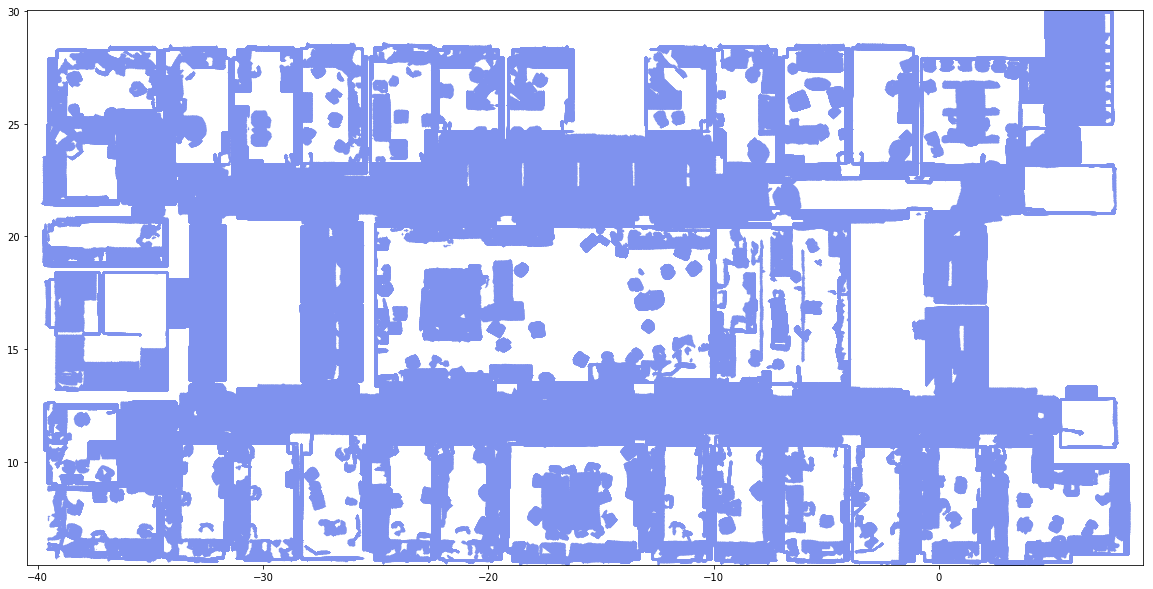

In [66]:
#VOXEL_GRID = 0.03
#cloud03 = open3d.voxel_down_sample(cloud,VOXEL_GRID)

(floor,ceiling,z_histogram) = get_floorceiling(cloud)
print("Floor level = " + str(floor))
print("Celing level = " + str(ceiling))

minbox = cloud.get_min_bound()
maxbox = cloud.get_max_bound()
ROOF_CEILING_PADDING = (ceiling - floor)*0.1
new_cloud = open3d.crop_point_cloud(cloud,[minbox[0],minbox[1],floor + ROOF_CEILING_PADDING],[maxbox[0],maxbox[1],ceiling - ROOF_CEILING_PADDING])
plot_2d([new_cloud],size = -1,axis_range=[minbox[0],maxbox[0],minbox[1],maxbox[1]],show_axis=True)

In [64]:
#x = -50
#y = -25
#new_cloud02 = open3d.crop_point_cloud(cloud,[x,y,floor + ROOF_CEILING_PADDING],[x+10,y+10,ceiling - ROOF_CEILING_PADDING])
#plot_2d([new_cloud02],size = -1,axis_range=[minbox[0],maxbox[0],minbox[1],maxbox[1]],show_axis=True)

#new_cloud = open3d.crop_point_cloud(cloud,[x,y,floor - ROOF_CEILING_PADDING],[x+10,y+10,ceiling + ROOF_CEILING_PADDING])
#open3d.write_point_cloud('../data/TEST/data/1950-charleston-road/L2{}_{}.ply'.format(x,y), new_cloud)

In [110]:
xmin = minbox[0]-3
ymin = minbox[1]
xmax = maxbox[0]+3
ymax = maxbox[1]

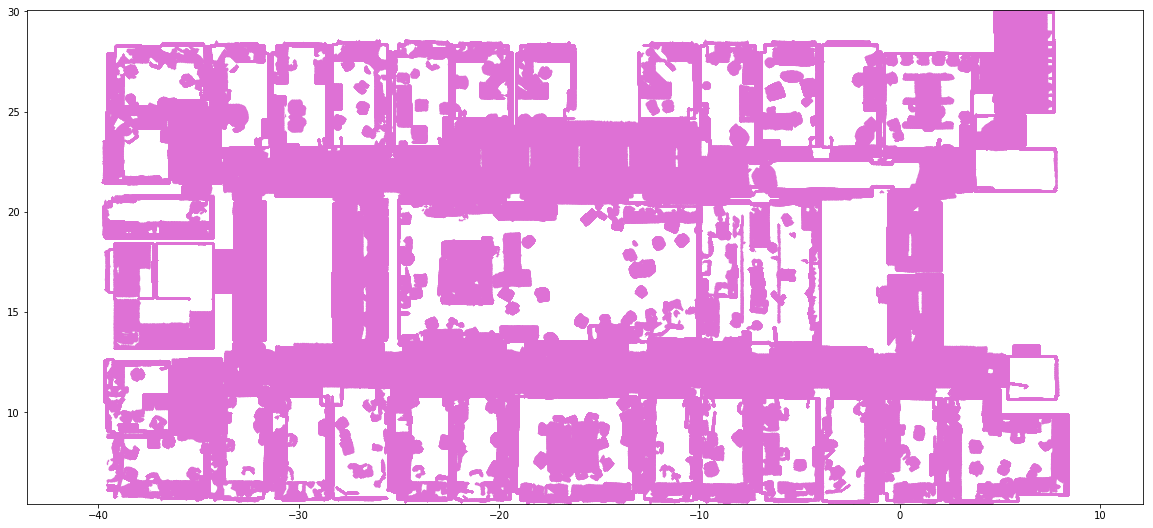

In [83]:
new_cloud = open3d.crop_point_cloud(cloud,[xmin,ymin,floor + ROOF_CEILING_PADDING],[xmax,ymax,ceiling - ROOF_CEILING_PADDING])
plot_2d([new_cloud],size = -1,axis_range=[xmin,xmax,ymin,ymax],show_axis=True)

I am cropping the point cloud in a row order from left to right.

In [106]:
w = math.ceil((xmax-xmin)/6)
h = math.ceil((ymax-ymin)/6)
print(' width : {} ; height : {}'.format(w,h))
rooms = {}
for y in range(1,h+1):
    for x in range(1,w+1):
        rooms['outfile_{}_{}'.format(y,x)]=  '../data/custom_S3DIS_augmented/data/Area_1_bis/crop_{}_{}.txt'.format(y,x)

 width : 10 ; height : 5


In [114]:
delimiter = ' ' 
with open(INPUT_FILE, 'r') as in_file:
    for line in in_file:
        X = np.array(line.split(delimiter), dtype='float32')
        x,y,z = X[0], X[1], X[2]
        r,g,b = X[3].astype('uint8'), X[4].astype('uint8'), X[5].astype('uint8')
        ol, oi, rl, ri = X[6].astype('uint8'), X[7].astype('uint8'), X[8].astype('uint8'), X[9].astype('uint8')
        if y-ymin <= 0 :
            row = 1
        else :
            row = math.ceil((y-ymin)/6)
        if x-xmin <= 0 :
            col = 1
        else :
            col = math.ceil((x-xmin)/6)
        
        outfile = rooms['outfile_{}_{}'.format(row, col)]
        with open(outfile, 'a') as out_file:
            out_file.write(str(x)+' '+str(y)+' '+str(z)+' '+str(r)+' '+str(g)+' '+str(b)+' '+str(ol)+' '+str(oi)+' '+str(rl)+' '+str(ri)+'\n' )

KeyboardInterrupt: 

In [5]:
print('=========================== 1 =======================================')
for number in range(1,7):
    INPUT_FILE = '../S3DIS_full/Area_{}.txt'.format(number) 
    print(INPUT_FILE)
    cloud = open3d.read_point_cloud(INPUT_FILE,  format='xyz')

    minbox = cloud.get_min_bound()
    maxbox = cloud.get_max_bound()

    xmin = minbox[0] - 3
    ymin = minbox[1]
    xmax = maxbox[0] + 3
    ymax = maxbox[1]

    w = math.ceil((xmax-xmin)/6)
    h = math.ceil((ymax-ymin)/6)
    print(' width : {} ; height : {}'.format(w,h))
    rooms = {}
    for y in range(1,h+1):
        for x in range(1,w+1):
            rooms['outfile_{}_{}'.format(y,x)]=  '../data/custom_S3DIS_augmented/data/Area_{}/Acrop_{}_{}.txt'.format(number,y,x)

    delimiter = ' ' 
    with open(INPUT_FILE, 'r') as in_file:
        for line in in_file:
            X = np.array(line.split(delimiter), dtype='float32')
            x,y,z = X[0], X[1], X[2]
            r,g,b = X[3].astype('uint8'), X[4].astype('uint8'), X[5].astype('uint8')
            ol = X[6].astype('uint8') 
            if y-ymin <= 0 :
                row = 1
            else :
                row = math.ceil((y-ymin)/6)
            if x-xmin <= 0 :
                col = 1
            else :
                col = math.ceil((x-xmin)/6)

            outfile = rooms['outfile_{}_{}'.format(row, col)]
            with open(outfile, 'a') as out_file:
                out_file.write(str(x)+' '+str(y)+' '+str(z)+' '+str(r)+' '+str(g)+' '+str(b)+' '+str(ol)+'\n' )
                out_file.close()

print('=========================== 2 =======================================')        
for number in range(1,7):
    INPUT_FILE = '../S3DIS_full/Area_{}.txt'.format(number) 
    print(INPUT_FILE)
    cloud = open3d.read_point_cloud(INPUT_FILE,  format='xyz')

    minbox = cloud.get_min_bound()
    maxbox = cloud.get_max_bound()

    xmin = minbox[0]
    ymin = minbox[1] - 3
    xmax = maxbox[0]
    ymax = maxbox[1] + 3

    w = math.ceil((xmax-xmin)/6)
    h = math.ceil((ymax-ymin)/6)
    print(' width : {} ; height : {}'.format(w,h))
    rooms = {}
    for y in range(1,h+1):
        for x in range(1,w+1):
            rooms['outfile_{}_{}'.format(y,x)]=  '../data/custom_S3DIS_augmented/data/Area_{}/Bcrop_{}_{}.txt'.format(number,y,x)

    delimiter = ' ' 
    with open(INPUT_FILE, 'r') as in_file:
        for line in in_file:
            X = np.array(line.split(delimiter), dtype='float32')
            x,y,z = X[0], X[1], X[2]
            r,g,b = X[3].astype('uint8'), X[4].astype('uint8'), X[5].astype('uint8')
            ol = X[6].astype('uint8')
            if y-ymin <= 0 :
                row = 1
            else :
                row = math.ceil((y-ymin)/6)
            if x-xmin <= 0 :
                col = 1
            else :
                col = math.ceil((x-xmin)/6)

            outfile = rooms['outfile_{}_{}'.format(row, col)]
            with open(outfile, 'a') as out_file:
                out_file.write(str(x)+' '+str(y)+' '+str(z)+' '+str(r)+' '+str(g)+' '+str(b)+' '+str(ol)+'\n' )
                out_file.close()
    
    
print('=========================== 3 =======================================')
for number in range(1,7):
    INPUT_FILE = '../S3DIS_full/Area_{}.txt'.format(number) 
    print(INPUT_FILE)
    cloud = open3d.read_point_cloud(INPUT_FILE,  format='xyz')

    minbox = cloud.get_min_bound()
    maxbox = cloud.get_max_bound()

    xmin = minbox[0] - 3
    ymin = minbox[1] - 3
    xmax = maxbox[0] + 3
    ymax = maxbox[1] + 3

    w = math.ceil((xmax-xmin)/6)
    h = math.ceil((ymax-ymin)/6)
    print(' width : {} ; height : {}'.format(w,h))
    rooms = {}
    for y in range(1,h+1):
        for x in range(1,w+1):
            rooms['outfile_{}_{}'.format(y,x)]=  '../data/custom_S3DIS_augmented/data/Area_{}/Ccrop_{}_{}.txt'.format(number,y,x)

    delimiter = ' ' 
    with open(INPUT_FILE, 'r') as in_file:
        for line in in_file:
            X = np.array(line.split(delimiter), dtype='float32')
            x,y,z = X[0], X[1], X[2]
            r,g,b = X[3].astype('uint8'), X[4].astype('uint8'), X[5].astype('uint8')
            ol = X[6].astype('uint8')
            if y-ymin <= 0 :
                row = 1
            else :
                row = math.ceil((y-ymin)/6)
            if x-xmin <= 0 :
                col = 1
            else :
                col = math.ceil((x-xmin)/6)

            outfile = rooms['outfile_{}_{}'.format(row, col)]
            with open(outfile, 'a') as out_file:
                out_file.write(str(x)+' '+str(y)+' '+str(z)+' '+str(r)+' '+str(g)+' '+str(b)+' '+str(ol)+'\n' )
                out_file.close()

=========================== 1 =======================================
../S3DIS_full/Area_1.txt
 width : 10 ; height : 5
../S3DIS_full/Area_2.txt
 width : 10 ; height : 6
../S3DIS_full/Area_3.txt
 width : 6 ; height : 5
../S3DIS_full/Area_4.txt
 width : 9 ; height : 5
../S3DIS_full/Area_5.txt
 width : 13 ; height : 8
../S3DIS_full/Area_6.txt
 width : 9 ; height : 4
=========================== 2 =======================================
../S3DIS_full/Area_1.txt
 width : 9 ; height : 6
../S3DIS_full/Area_2.txt
 width : 9 ; height : 7
../S3DIS_full/Area_3.txt
 width : 5 ; height : 6
../S3DIS_full/Area_4.txt
 width : 8 ; height : 6
../S3DIS_full/Area_5.txt
 width : 12 ; height : 9
../S3DIS_full/Area_6.txt
 width : 8 ; height : 5
=========================== 3 =======================================
../S3DIS_full/Area_1.txt
 width : 10 ; height : 6
../S3DIS_full/Area_2.txt
 width : 10 ; height : 7
../S3DIS_full/Area_3.txt
 width : 6 ; height : 6
../S3DIS_full/Area_4.txt
 width : 9 ; height : 6


In [ ]:
area = np.genfromtxt(INPUT_FILE, delimiter=' ')

xyz = np.array(area[:, 0:3], dtype='float32')
rgb = np.array(area[:, 3:6], dtype='uint8')
object_label = np.array(area[:, 6], dtype='uint8')
object_id = np.array(area[:, 7], dtype='uint8')
room_label = np.array(area[:, 8], dtype='uint8')
room_id = np.array(area[:, 9], dtype='uint8')

In [ ]:
nRows = area.shape[0]

for i in range(nRows):
    x,y,z = xyz[i,0], xyz[i,1], xyz[i,2]
    r,g,b = rgb[i,0], rgb[i,1], rgb[i,2]
    ol, oi, rl, rl = object_label[i], object_id[i], room_label[i], room_id[i]
    row = math.ceil(y-ymin/6)
    col = math.ceil(x-xmin/6)
    outfile = rooms['outfile_{}'.format(w*(row-1)+col)]
    with open(outfile, 'a') as outfile:
        out_file.write(x+' '+y+' '+z+' '+r+' '+g+' '+b+' '+ol+' '+oi+' '+rl+' '+ri+'\n' )

In [20]:
# generating 6x6 'rooms' by dividing the point cloud according to a grid
n = 0
ymin = minbox[1]
while ymin < maxbox[1]:
    xmin = minbox[0]
    while xmin < maxbox[0]:
        n += 1
        crop = open3d.crop_point_cloud(cloud,[xmin,ymin,floor - ROOF_CEILING_PADDING],[xmin+6, ymin+6, ceiling + ROOF_CEILING_PADDING])
        open3d.write_point_cloud('../data/custom_S3DIS/data/Area_1/crop_{}.ply'.format(n), crop)
        xmin += 6
    ymin += 6
        

In [21]:
n

45

## Normalizing rooms


In [3]:
INPUT_FILE = '../data/TEST/data/test/test_02.ply' #'../data/custom_S3DIS/data/Area_1/crop_9.txt' superpoint_graph/data/helix_bis/data/test/crop_13-Copy1.ply
cloud = open3d.read_point_cloud(INPUT_FILE) # when reading from .txt files 
#open3d.write_point_cloud('../data/helix/data/test/crop_12_NA.ply', cloud)

In [4]:
# Align x,y,z with  origin
pts = np.asarray(cloud.points)
pts = pts  - np.min(pts,axis=0,keepdims=True) 

In [8]:
pts[:,:2] = (pts[:,:2] - np.min(pts[:,:2],axis=0,keepdims=True) )/(np.max(pts[:,:2],axis=0,keepdims=True)  - np.min(pts[:,:2],axis=0,keepdims=True) ) - 0.5

In [26]:
# Normalizing x, y between -0.5 and 0.5
x_min = np.min(pts[:,0])
x_max = np.max(pts[:,0])
y_min = np.min(pts[:,1])
y_max = np.max(pts[:,1])

In [27]:
pts[:,0] = (pts[:,0] - x_min)/(x_max - x_min) - 0.5
pts[:,1] = (pts[:,1] - y_min)/(y_max - y_min) - 0.5

In [9]:
for i in range(pts.shape[1]):
    print("Feature "+ str(i)+"; Min: " + str(np.min(pts[:,i])) + "; Max: " + str(np.max(pts[:,i]) ))

Feature 0; Min: -0.5; Max: 0.5
Feature 1; Min: -0.5; Max: 0.5
Feature 2; Min: 0.0; Max: 3.7849998


In [40]:
cloud.points = open3d.Vector3dVector(pts)

In [42]:
open3d.write_point_cloud('../data/helix/data/test/crop_12.ply', cloud)

True

In [ ]:
'../data/custom_S3DIS/data/Area_5/crop_15.txt'

## Getting element from a point cloud

In [35]:
INPUT_FILE = '../data/custom_S3DIS_bis/data/Area_1/crop_20.txt'
OUTPUT_FILE = '../data/debug_partition/data/Area_1/A1_19_20_28_29_bis.txt'
delimiter = ' '
with open(OUTPUT_FILE, 'a') as out_file:
    with open(INPUT_FILE, 'r') as in_file:
        for line in in_file:
            out_file.write(line)

In [5]:
INPUT_FILE = '../data/custom_S3DIS/data/Area_5/crop_15.txt'
room_ver = np.genfromtxt(INPUT_FILE, delimiter=' ')
xyz = np.array(room_ver[:, 0:3], dtype='float32')
rgb = np.array(room_ver[:, 3:6], dtype='uint8')
room_labels = np.array(room_ver[:, 6], dtype='uint8')

In [12]:
room_labels

array([ 0,  0,  0, ..., 12, 12, 12], dtype=uint8)

In [21]:
INPUT_FILE = '../data/custom_S3DIS_bis/data/Area_1/crop_19.txt'
i = 0
with open(INPUT_FILE, 'r') as in_file:
    for line in in_file:
        i+= 1

In [22]:
i

1717206

In [26]:
INPUT_FILE = '../data/TEST/data/test/A1crop_19.ply'
cloud = open3d.read_point_cloud(INPUT_FILE) # when reading from .txt files 

In [27]:
cloud.points

std::vector<Eigen::Vector3d> with 1717206 elements.
Use numpy.asarray() to access data.

In [ ]:
# extracting point with a particular label from the point cloud
i_label = 0
cloud = xyz[np.where(xyz_labels == i_label)]
# converting simple array to open3d.PointCloud object
pcd = o3d.PointCloud()
pcd.points = o3d.Vector3dVector(cloud)
o3d.write_point_cloud('floor.ply', pcd)